In [0]:
!ls

my_model.h5  ratings.dat  sample_data  u1.test


In [0]:
import tensorflow as tf
graph = tf.get_default_graph()

# **Deep Recommend**

In [16]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
import numpy as np
import pandas as pd

In [0]:
ff = 'ratings.dat'

In [6]:
name = ['user', 'item', 'rating', 'time']
dff = pd.read_csv(ff, sep='::', names = name)
dff = dff.drop(columns = ['time'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [7]:
dff.head()

,user,item,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [0]:
data_dim = len(dff.user.unique()), len(dff.item.unique())

In [9]:
data_dim

(6040, 3706)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
data = np.array(dff)
train, test = train_test_split(data, test_size=0.2)

In [0]:
u_train = train[:,0]
i_train = train[:,1]
r_train = train[:,2]
u_test = test[:,0]
i_test = test[:,1]
r_test = test[:,2]

In [0]:
# r_train = r_train/5
# r_test = r_test/5

In [13]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import dot, concatenate, Embedding, Input, Flatten, Dropout, Dense, add
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras import backend as K

Using TensorFlow backend.


In [0]:
len_dim_i = [100,200,300]
len_dim_u = [100,200,300]
len_dim_r = [100]

In [0]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [0]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

user_embedding = Embedding(output_dim=10, input_dim=data_dim[0] + 1,
                                   input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=10, input_dim=data_dim[1] + 1,
                                   input_length=1, name='item_embedding')(item_id_input)
#user-item init
# user_layer = (Dense(100, activation="relu"))(user_id_input)
# item_layer = (Dense(100, activation="relu"))(item_id_input)
# sub_layer_user = add([user_embedding, user_id_input])
# sub_layer_item = add([item_embedding, item_id_input])


# user_embedding = (Dense(100, activation="relu"))(user_embedding)
# item_embedding = (Dense(100, activation="relu"))(item_embedding)
# sub_layer_user = (Dense(100, activation="relu"))(sub_layer_user)
# sub_layer_item = (Dense(100, activation="relu"))(sub_layer_item)

# for i in range(len(len_dim_u)):
#     user_embedding = (Dense(len_dim_u[i], activation="relu"))(user_embedding)
#     user_embedding = (Dropout(0.1))(user_embedding)
# for i in range(len(len_dim_i)):
#     item_embedding = (Dense(len_dim_i[i], activation="relu"))(item_embedding)
#     item_embedding = (Dropout(0.1))(item_embedding)

# sub_layer_user = add([user_embedding, user_layer])
# sub_layer_item = add([item_embedding, item_layer])
#1st block
user_embedding = (Dense(100, activation="relu", name = "user_dense1"))(user_embedding)
user_embedding = (BatchNormalization(name="batch_user1"))(user_embedding)
item_embedding = (Dense(100, activation="relu",name = "item_dense1"))(item_embedding)
item_embedding = (BatchNormalization(name="batch_item1"))(item_embedding)

sub_layer_user = (Dense(100, activation="relu", name = "subuser_layer1"))(user_id_input)
sub_layer_item = (Dense(100, activation="relu", name = "subitem_layer1"))(item_id_input)
#xcep
sub_layer_user = add([user_embedding, sub_layer_user])
sub_layer_item = add([item_embedding, sub_layer_item])

user_embedding = (Dense(150, activation="relu", name = "user_dense2"))(user_embedding)
user_embedding = (BatchNormalization(name="batch_user2"))(user_embedding)
item_embedding = (Dense(150, activation="relu", name = "item_dense2"))(item_embedding)
item_embedding = (BatchNormalization(name="batch_item2"))(item_embedding)

sub_layer_user = (Dense(150, activation="relu",name = "subuser_layer2"))(user_id_input)
sub_layer_item = (Dense(150, activation="relu",name = "subitem_layer2"))(item_id_input)
#xcep
sub_layer_user = add([user_embedding, sub_layer_user])
sub_layer_item = add([item_embedding, sub_layer_item])

#2nd block
user_embedding = (Dense(200, activation="relu", name = "user_dense3"))(user_embedding)
user_embedding = (BatchNormalization(name="batch_user3"))(user_embedding)
item_embedding = (Dense(200, activation="relu", name = "item_dense3"))(item_embedding)
item_embedding = (BatchNormalization(name="batch_item3"))(item_embedding)

sub_layer_user = (Dense(200, activation="relu",name = "subuser_layer3"))(sub_layer_user)
sub_layer_item = (Dense(200, activation="relu",name = "subitem_layer3"))(sub_layer_item)

user_embedding = add([user_embedding, sub_layer_user])
item_embedding = add([item_embedding, sub_layer_item])

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

    
# y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
y = add([user_vecs, item_vecs])
# # y = (Dense(1, activation="relu"))(y)
# for i in range(len(len_dim_r)):
#     y = (Dense(len_dim_r[i], activation="relu"))(y)
#     y = (BatchNormalization())(y)
#     y = (Dropout(0.2))(y)
# y = Dense(1, activation="relu")(y)
# M = Sequential()
# M.add(y)
# y = (Dropout(0.25))(y)
y = (Dense(100, activation="relu", name = "fc1"))(y)
y = (BatchNormalization())(y)
y = (Dropout(0.2))(y)
y = (Dense(32, activation="relu", name = "fc2"))(y)
# y = (Dropout(0.25))(y)
# y = (Dense(16))(y)
# y = (Dropout(0.1))(y)
y = (Dense(4, activation="relu", name = "fc3"))(y)
# y = (Dropout(0.2))(y)
y = (Dense(1, activation='relu'))(y)

model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mae', metrics=['mse'])

In [38]:
history = model.fit([u_train,i_train], r_train,validation_data=([u_test,i_test], r_test), batch_size=64, epochs = 25, verbose=1, shuffle=True)

Train on 800167 samples, validate on 200042 samples
Epoch 1/25
800167/800167 [==============================] - 325s 407us/step - loss: 0.8084 - mean_squared_error: 1.0712 - val_loss: 0.8882 - val_mean_squared_error: 2.9714
Epoch 2/25
800167/800167 [==============================] - 317s 396us/step - loss: 0.7343 - mean_squared_error: 0.9149 - val_loss: 0.8903 - val_mean_squared_error: 1.5407
Epoch 3/25
800167/800167 [==============================] - 321s 401us/step - loss: 0.7074 - mean_squared_error: 0.9214 - val_loss: 0.8704 - val_mean_squared_error: 1.4299
Epoch 4/25
800167/800167 [==============================] - 318s 397us/step - loss: 0.6994 - mean_squared_error: 0.9259 - val_loss: 0.8699 - val_mean_squared_error: 1.3922
Epoch 5/25
800167/800167 [==============================] - 319s 399us/step - loss: 0.6942 - mean_squared_error: 0.9273 - val_loss: 0.8704 - val_mean_squared_error: 1.3966
Epoch 6/25
800167/800167 [==============================] - 317s 396us/step - loss: 0.68

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        60410       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        37070       item[0][0]                       
__________________________________________________________________________________________________
user_dense

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

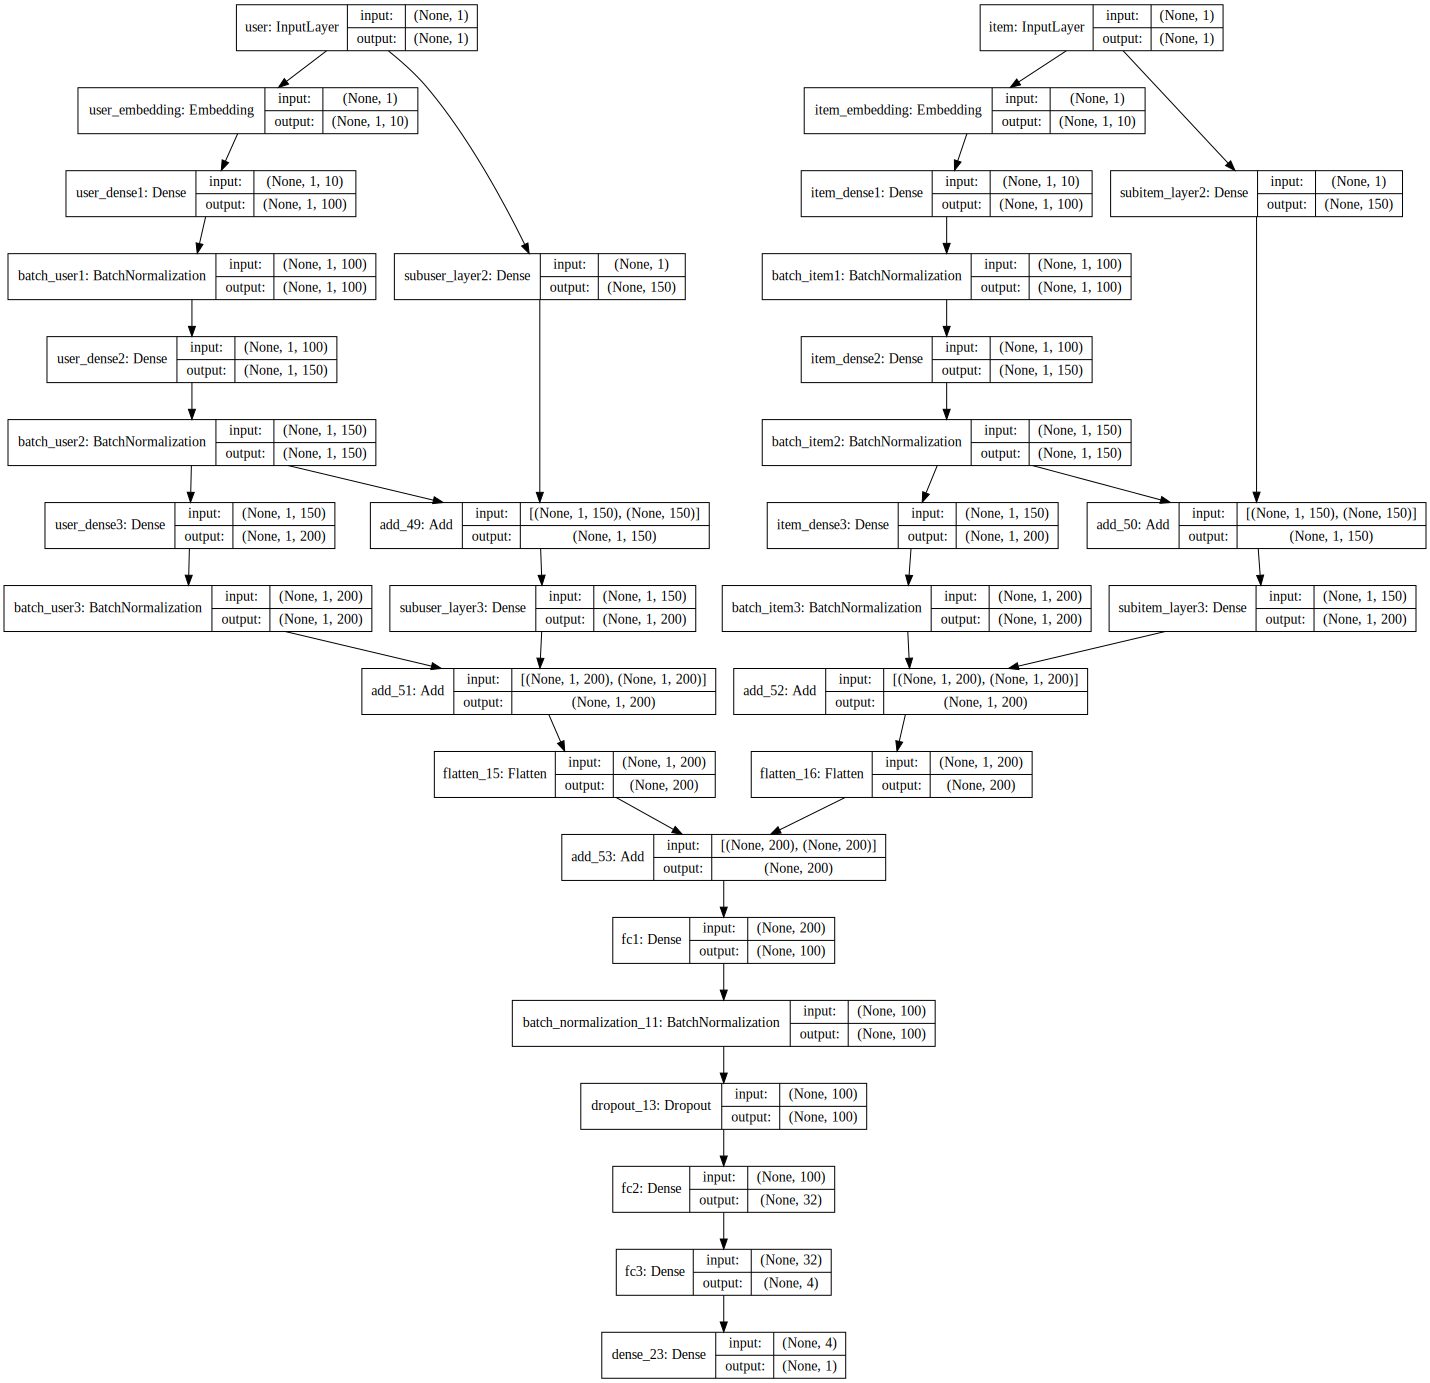

In [40]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
# print(history)

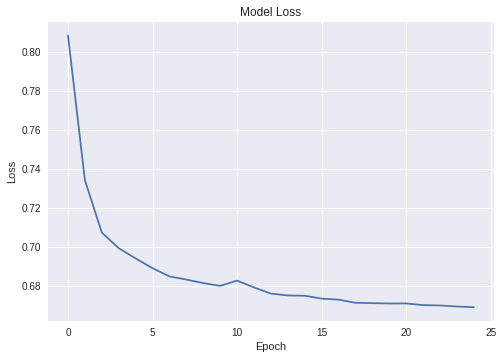

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()